In [6]:
!pip install tensorflow-addons

In [7]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

print("TensorFlow Version:", tf.__version__)




TensorFlow Version: 2.8.0


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
base_dir = "/content/drive/MyDrive/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['NonDemented', 'ModerateDemented', 'VeryMildDemented', 'MildDemented']


In [10]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [11]:
#Performing Image Augmentation to have more data samples
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


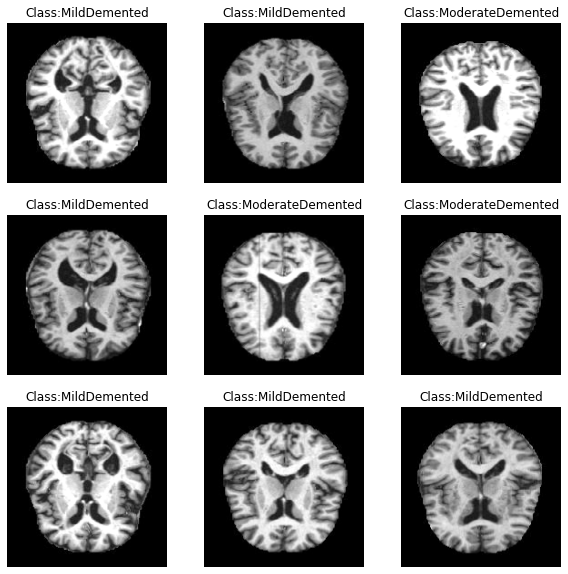

In [12]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [13]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

In [14]:
#Getting to know the dimensions of our dataset
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

In [ ]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [ ]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [ ]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [ ]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 176, 176, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 176, 176, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 88, 88, 16)        0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 44, 44, 32)        14016     
_________________________________________________________________
sequential_8 (Sequential)    (None, 22, 22, 64)        55680     
_________________________________________________________________
sequential_9 (Sequential)    (None, 11, 11, 128)       221952    
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 128)       0 

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
256/256 [==============================] - 498s 2s/step - loss: 0.5328 - acc: 0.7710 - auc: 0.9488 - f1_score: 0.7706 - val_loss: 0.5410 - val_acc: 0.7554 - val_auc: 0.9452 - val_f1_score: 0.7540
Epoch 2/50
256/256 [==============================] - 450s 2s/step - loss: 0.4748 - acc: 0.7998 - auc: 0.9589 - f1_score: 0.7986 - val_loss: 0.5695 - val_acc: 0.7446 - val_auc: 0.9450 - val_f1_score: 0.7165
Epoch 3/50
256/256 [==============================] - 447s 2s/step - loss: 0.4316 - acc: 0.8198 - auc: 0.9660 - f1_score: 0.8189 - val_loss: 0.8749 - val_acc: 0.6855 - val_auc: 0.9060 - val_f1_score: 0.6727
Epoch 4/50
256/256 [==============================] - 449s 2s/step - loss: 0.4056 - acc: 0.8352 - auc: 0.9697 - f1_score: 0.8345 - val_loss: 0.3933 - val_acc: 0.8311 - val_auc: 0.9716 - val_f1_score: 0.8253
Epoch 5/50
256/256 [==============================] - 442s 2s/step - loss: 0.3293 - acc: 0.8704 - auc: 0.9798 - f1_score: 0.8699 - val_loss: 1.5249 - val_acc: 0.4810 - val_

256/256 [==============================] - 383s 1s/step - loss: 0.0540 - acc: 0.9829 - auc: 0.9990 - f1_score: 0.9829 - val_loss: 0.2274 - val_acc: 0.9287 - val_auc: 0.9900 - val_f1_score: 0.9279
Epoch 41/50
256/256 [==============================] - 383s 1s/step - loss: 0.0369 - acc: 0.9886 - auc: 0.9994 - f1_score: 0.9886 - val_loss: 0.2697 - val_acc: 0.9272 - val_auc: 0.9868 - val_f1_score: 0.9266
Epoch 42/50
256/256 [==============================] - 384s 1s/step - loss: 0.0461 - acc: 0.9844 - auc: 0.9989 - f1_score: 0.9844 - val_loss: 0.2519 - val_acc: 0.9385 - val_auc: 0.9857 - val_f1_score: 0.9383
Epoch 43/50
256/256 [==============================] - 382s 1s/step - loss: 0.0570 - acc: 0.9844 - auc: 0.9985 - f1_score: 0.9844 - val_loss: 0.2271 - val_acc: 0.9365 - val_auc: 0.9897 - val_f1_score: 0.9368
Epoch 44/50
256/256 [==============================] - 385s 2s/step - loss: 0.0381 - acc: 0.9879 - auc: 0.9993 - f1_score: 0.9879 - val_loss: 0.2472 - val_acc: 0.9370 - val_auc: 0.

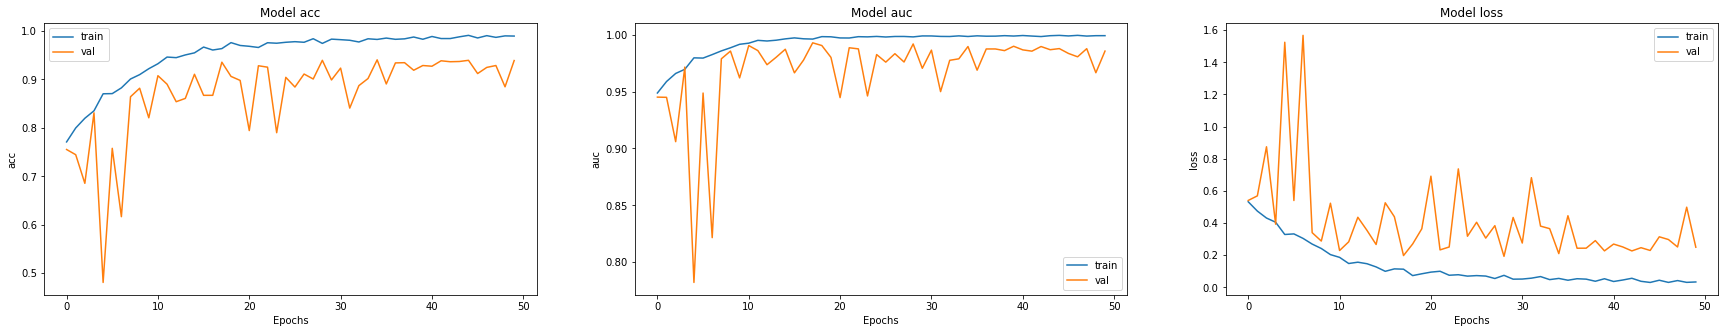

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
#Evaluating the model on the data

train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 22s 277ms/step - loss: 0.2112 - acc: 0.9477 - auc: 0.9873 - f1_score: 0.9479
Training Accuracy: 99.82%
Validation Accuracy: 93.90%
Testing Accuracy: 94.77%


In [ ]:
#Predicting the test data

pred_labels = model.predict(test_data)

In [ ]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.98      0.98      0.98       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.93      0.88      0.90       662
ModerateDemented       0.88      0.93      0.90       624

       micro avg       0.95      0.95      0.95      2560
       macro avg       0.95      0.95      0.95      2560
    weighted avg       0.95      0.95      0.95      2560
     samples avg       0.95      0.95      0.95      2560



In [ ]:
#Saving the model for future use

model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [ ]:
pretrained_model = tf.keras.models.load_model(model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
